In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import curve_fit


import math
from skimage import color
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import skimage.draw as sdraw
from skimage.util import img_as_ubyte

from skimage.morphology import binary_closing, disk, erosion, dilation
import scipy.ndimage as nd
import skimage.draw as sdraw

from matplotlib import colors
from skimage.measure import label, regionprops

In [15]:
# #6ms 20FA
# DICOM1 = 'NPERIODIC_140423_1.MR.0003.0001.2023.04.14.15.23.33.996403.63216740.IMA'
# DICOM2 = 'NPERIODIC_140423_1.MR.0003.0002.2023.04.14.15.23.33.996403.63216758.IMA'
# DICOM3 = 'NPERIODIC_140423_1.MR.0003.0003.2023.04.14.15.23.33.996403.63216776.IMA'
# DICOM4 = 'NPERIODIC_140423_1.MR.0003.0004.2023.04.14.15.23.33.996403.63216794.IMA'
# DICOM5 = 'NPERIODIC_140423_1.MR.0003.0005.2023.04.14.15.23.33.996403.63216812.IMA'
# DICOM6 = 'NPERIODIC_140423_1.MR.0003.0006.2023.04.14.15.23.33.996403.63216830.IMA'
# DICOM7 = 'NPERIODIC_140423_1.MR.0003.0007.2023.04.14.15.23.33.996403.63216848.IMA'
# DICOM8 = 'NPERIODIC_140423_1.MR.0003.0008.2023.04.14.15.23.33.996403.63216866.IMA'
# DICOM9 = 'NPERIODIC_140423_1.MR.0003.0009.2023.04.14.15.23.33.996403.63216884.IMA'
# DICOM10 = 'NPERIODIC_140423_1.MR.0003.0010.2023.04.14.15.23.33.996403.63216902.IMA'
# DICOM11 = 'NPERIODIC_140423_1.MR.0003.0011.2023.04.14.15.23.33.996403.63216920.IMA'
# DICOM12 = 'NPERIODIC_140423_1.MR.0003.0012.2023.04.14.15.23.33.996403.63216938.IMA'
# DICOMFILENAME = [DICOM1,DICOM2,DICOM3,DICOM4,DICOM5,DICOM6,DICOM7,DICOM8,DICOM9,DICOM10,DICOM11,DICOM12]

In [122]:
# LastCODE = 63238286
# specialCODE = '0031'
# fa = 90
# tr = 8
# TR = 8e-3
# TE = TR/2 
# echonum = 10

# DICOMFILENAME = []
# for i in range (0,echonum):
#     LAST = str(LastCODE+18*i)
#     if(i<9):
#          DICOM1 = 'DICOM/GOLDSTANDARD_'+str(tr)+'msTR_'+str(fa)+'FA/NPERIODIC_140423_1.MR.'+specialCODE+'.000'+str(int(i+1))+'.2023.04.14.15.23.33.996403.'+LAST+'.IMA'
#     else:
#         DICOM1 = 'DICOM/GOLDSTANDARD_'+str(tr)+'msTR_'+str(fa)+'FA/NPERIODIC_140423_1.MR.'+specialCODE+'.00'+str(int(i+1))+'.2023.04.14.15.23.33.996403.'+LAST+'.IMA'
#     DICOMFILENAME.append(DICOM1)
#     print(DICOM1)

DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0001.2023.04.14.15.23.33.996403.63238286.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0002.2023.04.14.15.23.33.996403.63238304.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0003.2023.04.14.15.23.33.996403.63238322.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0004.2023.04.14.15.23.33.996403.63238340.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0005.2023.04.14.15.23.33.996403.63238358.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0006.2023.04.14.15.23.33.996403.63238376.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0007.2023.04.14.15.23.33.996403.63238394.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0008.2023.04.14.15.23.33.996403.63238412.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0009.2023.04.14.15.23.33.996403.63238430.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0010.2023.04.14.15.23.33.

In [2]:
fa = 40
tr = 6
TR = tr*1e-3
TE = TR/2 
echonum = 12
DICOMFILENAME = []
for i in range (0,echonum):
    DICOM1 = 'recon/multiecho_FLASH/tr'+str(tr)+'_fa'+str(fa)+'_echo'+str(i+1)+'.dcm'

    DICOMFILENAME.append(DICOM1)

#LOAD DICOM DATA
GOLDSTD_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,echonum):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    GOLDSTD_DATA = np.append(GOLDSTD_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
GOLDSTD_DATA =  np.delete(GOLDSTD_DATA,0,0)
#pixel array for different TR stored in GOLDSTD_DATA



### USE STANDARD MASK

In [3]:
STANDARD_MASK_LABEL = np.load("Figure/MASKLABEL_2.npy")
STANDARD_MASK = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if(STANDARD_MASK_LABEL[i,j]>0):
            STANDARD_MASK[i,j]= 1

### Fitting to calculate R2* of the phantom

In [4]:
#R2* Fitting
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
R2StarImage = np.asarray([], dtype = float)
for x in range (0,256):
    for y in range (0,256):
        popt, pcov = curve_fit(func, TIME, GOLDSTD_DATA[:,x,y]*STANDARD_MASK[x,y])
        PixelR2Star = popt[1]
        R2StarImage = np.append(R2StarImage, PixelR2Star)
R2StarImage = R2StarImage.reshape(256,256)



C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


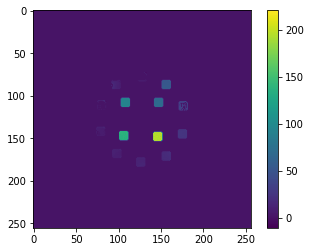

In [9]:
plt.imshow(R2StarImage)
plt.colorbar()

### T2* and Mean T2* value, Standard Deviation of T2* value in each circle

0.1430345542932921
0.027360110562539803
0.09064621212483372
0.01853427760434112
0.018641578669335256
0.0004867849571760009
0.010636210845434936
0.0001673152934048157
0.014439511878370725
0.00023506984847720304
0.12203224777966128
0.04053233145463041
0.031450605299241305
0.023072484267574713
0.1390037116110807
0.023037475753978826
0.04084578018375294
0.0009445952459419573
0.007367298432517967
0.00017630892784715476
0.00512909966391415
0.00012870058201299315
0.11124062661623368
0.014464816073360311
0.056606016213262736
0.003719055061833406
0.08109229191218856
0.005259831106457957


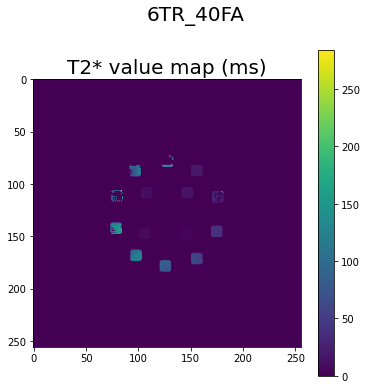

In [247]:
T2SMAP = np.zeros((256,256))
#Label the mask
LABELMASK = STANDARD_MASK_LABEL
MEAN = np.asarray([], dtype = float)
SD = np.asarray([], dtype = float)

for number in range (1,15):
    T2StarMeasured = np.asarray([], dtype = float)
    #Generate mask of one circle
    CircleMASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(LABELMASK[i,j]==number):
                CircleMASK[i,j] = 1

    #Only the R2* values of that circle remain
    R2MAP1 = R2StarImage*CircleMASK

#     T2StarinCircle = [1/x for x in R2MAP1.reshape(256*256) ]

# #     #remove outliers and calcuate mean and std of each circle 
#     mean = np.mean(T2StarinCircle, axis=0)
#     sd = np.std(T2StarinCircle, axis=0)
                  
#     final_list = [x for x in T2StarMeasured if (x > mean - 2 * sd)]
#     final_list = [x for x in final_list if (x < mean + 2 * sd)]
    # print(np.mean(final_list))
    # print(np.std(final_list))
    
    for i in range (0,256):
        for j in range (0,256):
            if(R2MAP1[i,j] > 1 ): #and 1/R2MAP1[i,j] > (mean - 2 * sd) and 1/R2MAP1[i,j] < (mean + 2 * sd)
                T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                #store T2*value in the T2* Map
                T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms
    MEAN = np.append(MEAN, np.mean(T2StarMeasured))
    SD = np.append(SD, np.std(T2StarMeasured))
    print(np.mean(T2StarMeasured))
    print(np.std(T2StarMeasured))


    # print("Phantom Circle "+str(number))
    # print("Mean: "+ str(np.mean(final_list)))
    # print("SD: "+ str(np.std(final_list)))

    
plt.figure(figsize = (6,6))
plt.imshow(T2SMAP)
plt.colorbar()

plt.suptitle(str(tr)+"TR_"+str(fa)+"FA", fontsize = 20)
plt.title("T2* value map (ms)", fontsize = 20)

plt.savefig("MASK_2RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.jpg")

In [248]:
np.save("MASK_2RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.npy", T2SMAP)
DATA = [MEAN, SD]
np.save("MASK_2RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_MEAN_STD.npy", DATA)

117.0

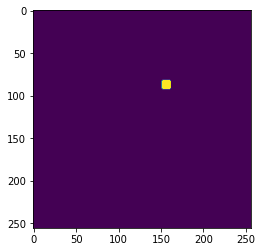

In [8]:
MASK_parts = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if (STANDARD_MASK_LABEL[i,j]==3):
            MASK_parts[i,j]=1
plt.imshow(MASK_parts)
np.sum(MASK_parts)

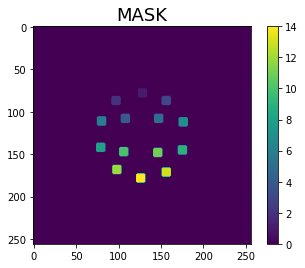

In [151]:

plt.imshow(LABELMASK)
plt.colorbar()
plt.title("MASK", fontsize = 18)
plt.savefig("MASK_2RESULT/GOLDstandardT2Star/MASK_2.jpg")

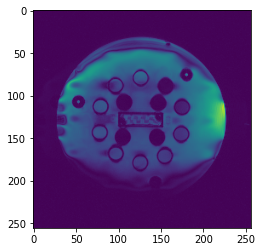

In [8]:
from IPython.display import clear_output
for i in range (0,12):
    plt.imshow(GOLDSTD_DATA[i,:,:])
    plt.show()
    clear_output(wait=True)
plt.show()
# image = GOLDSTD_DATA[0,:,:]
# hist, bin_edges = np.histogram(image)
# barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
# plt.bar(bin_edges[:-1], hist, width=barw, align='edge') 


20


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.12441783881854764
0.044318359087363084
0.0972768961163102
0.024043490635302915
0.02237645981520876
0.016955531781278548
0.016726532930979053
0.025993376733442826
0.01544997823298141
0.00713800797000463
0.11701901068370518
0.08094938958981553
0.032438185925958124
0.017529319397806956
0.13905923226143588
0.03758082399751538
0.04144653968835093
0.008870165338656475
0.009869022601872633
0.012334432913022261
0.010469500679305794
0.0217794014629834
0.10639488767168363
0.03017204591267663
0.05382783979555083
0.006875750037268852
0.07828757010839692
0.014850726445530265
40


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.13038908435352972
0.04199837612764841
0.09234264970580332
0.030114514338184312
0.020776631029585997
0.014611237061881976
0.013812682030054674
0.01483518274039098
0.014441252631290756
0.002522868359499064
0.12059634868125776
0.04822105848013536
0.030852061715287746
0.016853916273538532
0.13124148486752346
0.035537970146818636
0.04001048282028179
0.003086565046723657
0.009484007499932902
0.014847920168766793
0.008491229823917937
0.01619504221610531
0.10347792541988862
0.03206948440721105
0.05604195356288997
0.010004314226870481
0.07600998760382761
0.012624989632597778
60


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.18006594804297232
0.06884225653842761
0.0734050044236831
0.023205483310135482
0.01824824314765099
0.004426546127134387
0.01434836096645754
0.01716194550733048
0.014105713557650468
0.0015147728207959032
0.12209868052079006
0.026432703264459467
0.02748327730296311
0.003822323643742164
0.12301990357637647
0.030473716507046767
0.039898454079950074
0.0031665353564125243
0.009517862074597863
0.014543471907380713
0.0057497529612201585
0.004896446095569011
0.09911593166033507
0.025847746981588524
0.06106892658291781
0.02414121136096787
0.07434822531572063
0.016167037677638794
90


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq


0.150329821153898
0.06325928360556914
0.06191180617454633
0.015457034513284484
0.017819490399346005
0.004766902993793381
0.014994063948578364
0.01745318880459825
0.014224455257462711
0.004872345277819853
0.10698473931547746
0.024333332771561984
0.030402570183194408
0.023006330286858407
0.11283905285893724
0.030875606205115647
0.040429643706978456
0.003530885208422597
0.015014537356078833
0.030466207171833345
0.008926353005255126
0.015084085588799688
0.09761347972329967
0.023646882083060223
0.0599295997299484
0.015645102681703597
0.07471914664670046
0.01471166870784655


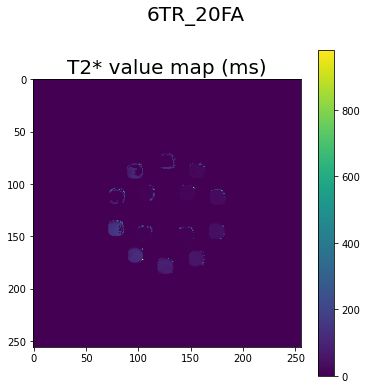

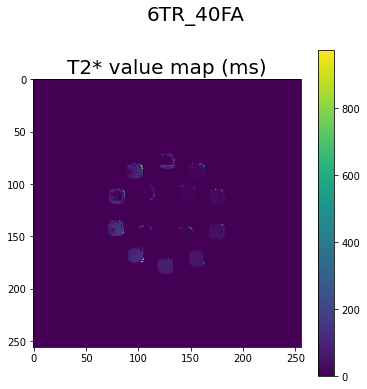

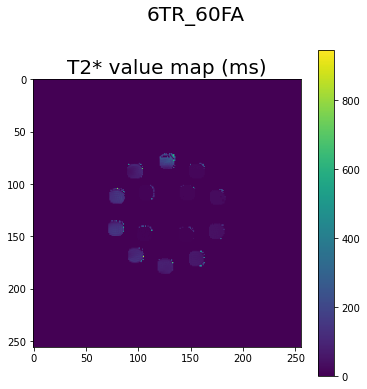

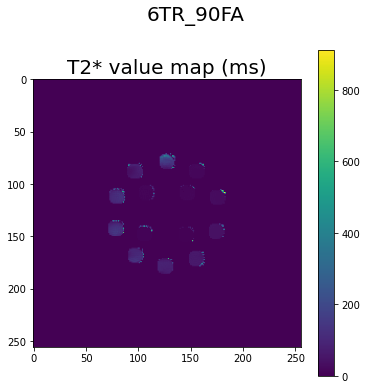

In [256]:
FA = [20, 40, 60, 90]
tr = 6
TR = tr*1e-3
TE = TR/2 
echonum = 12

for fa in FA:
    print(fa)
    DICOMFILENAME = []
    for i in range (0,echonum):
        DICOM1 = 'recon/multiecho_FLASH/tr'+str(tr)+'_fa'+str(fa)+'_echo'+str(i+1)+'.dcm'

        DICOMFILENAME.append(DICOM1)

    #LOAD DICOM DATA
    GOLDSTD_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
    TIME = np.asarray([], dtype = float)
    for i in range (0,echonum):
        filepath = DICOMFILENAME[i]
        img = pydicom.read_file(filepath)
        GOLDSTD_DATA = np.append(GOLDSTD_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
        #Corresponding "time" on exponential fit for each array layer
        TIME = np.append(TIME, TE + TR*i)
    GOLDSTD_DATA =  np.delete(GOLDSTD_DATA,0,0)
    #pixel array for different TR stored in GOLDSTD_DATA

    STANDARD_MASK_LABEL = np.load("Figure/MASK_1.npy")
    STANDARD_MASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(STANDARD_MASK_LABEL[i,j]>0):
                STANDARD_MASK[i,j]= 1

    #R2* Fitting
    def func(t, A, R2Star):
        return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
    R2StarImage = np.asarray([], dtype = float)
    for x in range (0,256):
        for y in range (0,256):
            popt, pcov = curve_fit(func, TIME, GOLDSTD_DATA[:,x,y]*STANDARD_MASK[x,y])
            PixelR2Star = popt[1]
            R2StarImage = np.append(R2StarImage, PixelR2Star)
    R2StarImage = R2StarImage.reshape(256,256)

    T2SMAP = np.zeros((256,256))
    #Label the mask
    LABELMASK = STANDARD_MASK_LABEL
    MEAN = np.asarray([], dtype = float)
    SD = np.asarray([], dtype = float)

    for number in range (1,15):
        T2StarMeasured = np.asarray([], dtype = float)
        #Generate mask of one circle
        CircleMASK = np.zeros((256,256))
        for i in range (0,256):
            for j in range (0,256):
                if(LABELMASK[i,j]==number):
                    CircleMASK[i,j] = 1

        #Only the R2* values of that circle remain
        R2MAP1 = R2StarImage*CircleMASK

        for i in range (0,256):
            for j in range (0,256):
                if(R2MAP1[i,j] > 1 ): #and 1/R2MAP1[i,j] > (mean - 2 * sd) and 1/R2MAP1[i,j] < (mean + 2 * sd)
                    T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                    #store T2*value in the T2* Map
                    T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms
        final_list = [x for x in T2StarMeasured if (x > np.mean(T2StarMeasured) - 2 * np.std(T2StarMeasured))]
        final_list = [x for x in final_list if (x < np.mean(T2StarMeasured) + 2 * np.std(T2StarMeasured))]
        print(np.mean(final_list))
        print(np.std(final_list))
        MEAN = np.append(MEAN, np.mean(final_list))
        SD = np.append(SD, np.std(final_list))



        # print("Phantom Circle "+str(number))
        # print("Mean: "+ str(np.mean(final_list)))
        # print("SD: "+ str(np.std(final_list)))


    plt.figure(figsize = (6,6))
    plt.imshow(T2SMAP)
    plt.colorbar()

    plt.suptitle(str(tr)+"TR_"+str(fa)+"FA", fontsize = 20)
    plt.title("T2* value map (ms)", fontsize = 20)

    plt.savefig("MASK_1RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.jpg")
    np.save("MASK_1RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.npy", T2SMAP)
    DATA = [MEAN, SD]
    np.save("MASK_1RESULT/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_MEAN_STD.npy", DATA)